## Image Preprocessing 

In [2]:
import os
import string
import random 
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
#import man_augmentation as aug
# https://albumentations.readthedocs.io/en/latest/examples.html
import albumentations as alb

# Access top level module 
sys.path.append('..')
from src.utils import get_rand_name
import src.data_augmentation as aug

%matplotlib inline
#plt.style.use('fivethirtyeight')
#plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 14

In [3]:
ROOT = "../input/"

In [4]:
def get_rand_name(size=30, chars=string.ascii_letters + string.digits):
    '''
    Generate Random filename
    rtype: a random string of length 30
    '''
    return ''.join(random.choice(chars) for x in range(size))

## Visualizing the dataset

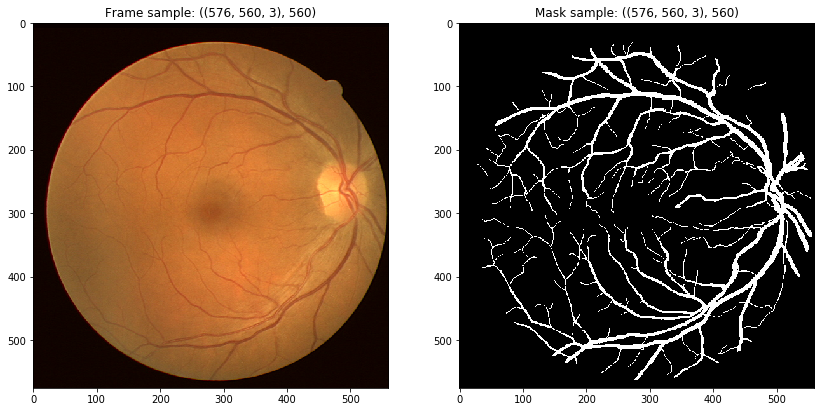

In [6]:
for (frame, mask) in zip(os.listdir(ROOT + 'training/images/'), os.listdir(ROOT + 'training/mask/')):
    #print(np.unique(color_mask(masks[i])))
    fig = plt.figure(figsize=(14,20))
    
    axs = fig.add_subplot(1,2,1)
    frame_img = plt.imread(ROOT + 'training/images/' + frame)
    axs.set_title(f"Frame sample: ({frame_img.shape}, {frame_img.shape[1]})")
    axs.imshow(frame_img )
    
    axs = fig.add_subplot(1,2,2)
    mask_img = plt.imread(ROOT + 'training/mask/' + frame) 
    axs.set_title(f"Mask sample: ({mask_img.shape}, {mask_img.shape[1]})")
    #mask_img[:, :] = (mask_img == 1).astype(int)
    axs.imshow(mask_img * 255)
    break

In [7]:
np.unique(mask_img)

array([0.        , 0.00392157], dtype=float32)

In [5]:
# Load image and slice then save as png 
def apply_crop(height, width, step_h, step_w,
               frame_in_path=None, 
               mask_in_path=None,
               frame_out_path=None,
               mask_out_path=None,
               center_crop=False):
    
    if not (os.path.isdir(frame_in_path) and
            os.path.isdir(mask_in_path) and
            os.path.isdir(frame_out_path) and
            os.path.isdir(mask_out_path)):
        raise Exception(f"Failed to load one of the given path")
    if not (height and width):
        raise Exception(f"Dimension not matched ({height}, {width})")
    if not (step_h and step_w):
        raise Exception(f"Step {step_h} or {step_w} not supported")
        
    for filename in os.listdir(frame_in_path):
        # Load frames and masks from npy source 
        frame_in = cv2.imread(os.path.join(frame_in_path, filename))
        mask_in = np.load(os.path.join(mask_in_path, filename.split('.')[0] + '.npy')) 

        for w in range(0, width, step_w):
            for h in range (0, height, step_h):
                frame_out = frame_in[h:h+step_h, w:w+step_w]
                mask_out = mask_in[h:h+step_h, w:w+step_w]
                rand_name = get_rand_name()
                cv2.imwrite(os.path.join(frame_out_path, rand_name + '.png'), frame_out)
                cv2.imwrite(os.path.join(mask_out_path, rand_name + '.png'), mask_out)

In [ ]:
# Crop images & mask(both in png format)
'''
apply_crop(720, 1280, 360, 320, 
          frame_in_path=ROOT + 'source/generated-v2-01/JPEGImages/',
          mask_in_path=ROOT + 'source/generated-v2-01/SegmentationClass/', 
          frame_out_path=ROOT + 'source/sliced-v2-01/images/',
          mask_out_path=ROOT + 'source/sliced-v2-01/mask/')
'''

## Image augmentation using Ablumentations

In [8]:
def apply_alb(p=0.7, frame_in_path=None, mask_in_path=None, frame_out_path=None, mask_out_path=None):
    # define augmentation pipeline
    pipeline = alb.Compose([
        alb.VerticalFlip(),
        alb.HorizontalFlip(),
        alb.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=1),
        alb.ElasticTransform(border_mode=cv2.BORDER_REFLECT_101, alpha_affine=40, p=1),
        alb.OneOf([
            alb.GaussianBlur(p=0.7, blur_limit=3),
            alb.RandomRain(p=0.7, brightness_coefficient=0.6, drop_width=1, blur_value=5),
            alb.RandomSnow(p=0.7, brightness_coeff=1, snow_point_lower=0.3, snow_point_upper=0.5),
            alb.RandomShadow(p=0.6, num_shadows_lower=1, num_shadows_upper=1, 
                            shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1)),
            alb.RandomFog(p=0.7, fog_coef_lower=0.7, fog_coef_upper=0.8, alpha_coef=0.1)
        ], p=0.8),
        alb.OneOf([
            alb.CLAHE(clip_limit=2),
            alb.IAASharpen(),
            alb.IAAEmboss(),
            alb.RandomBrightnessContrast(),
        ], p=0.6),
    ], p=p)
    
    # Apply pipeline for randomly picked image for 800 trial -> to generate 800 images
    for _ in range(800):
        # Shuffle out image list
        frame_list = os.listdir(frame_in_path)
        random.shuffle(frame_list)
        index = random.randint(0, len(frame_list)-1)
        # Pick one image 
        frame_id = frame_list[index]
        # Apply augmentation to the coosen image
        frame_in = cv2.imread(frame_in_path + frame_id)
        mask_in = cv2.imread(mask_in_path + frame_id)
        # Fit pipeline 
        augmented = pipeline(image = frame_in, mask = mask_in)
        # Get outcomes 
        frame_out, mask_out = augmented["image"], augmented["mask"]
        # Gen. out filename 
        f_name = get_rand_name()
        # Write file to out dir 
        cv2.imwrite(frame_out_path + f_name + '.png', frame_out)
        cv2.imwrite(mask_out_path + f_name + '.png', mask_out)

In [93]:
# Same as above, used for experimenting unique trasnformation
def apply_alb_exp(img_size=None,  # Should be divisible by 32(!required)
                   p=1,
                   fformat='png', 
                   frame_in_path=None, 
                   mask_in_path=None, 
                   frame_out_path=None, 
                   mask_out_path=None):
    
    # define augmentation pipeline
    transform = alb.Compose([
        #alb.GaussianBlur(p=0.8, always_apply=True, blur_limit=5),
        #alb.Blur(blur_limit=(15, 15), p=1),
        #alb.MedianBlur(p=0.8),
        alb.HorizontalFlip(p=0.7),
        alb.VerticalFlip(p=0.7),
        alb.RandomRotate90(p=0.4),
        alb.RandomContrast(limit=(0.2, 1), p=0.8),
        alb.RandomGamma(gamma_limit=(80, 100), p=0.8),
        #alb.RandomBrightness(limit=1, p=0.8),
        #alb.MultiplicativeNoise(multiplier=[0.5, 1.5], per_channel=True, p=1),
        #alb.RandomBrightnessContrast(p=0.9),
        alb.CLAHE(clip_limit=2, p=0.9), 
        
    ], p=p)
    # Apply pipeline for each image
    for frame_id in os.listdir(frame_in_path):
    # Apply pipeline for x randomly picked images
#     for _ in range(40):
#         # Shuffle out image list
#         frame_list = os.listdir(frame_in_path)
#         random.shuffle(frame_list)
#         index = random.randint(0, len(frame_list)-1)
#         # Pick one image 
#         frame_id = frame_list[index]
        #print(mask_in_path + frame_id.split('_')[0] + '_manual1.gif')
        # Apply augmentation to the coosen image
        frame_in = cv2.imread(os.path.join(frame_in_path, frame_id))
        if fformat == 'gif':
            mask_in = np.array(Image.open(os.path.join(mask_in_path, frame_id.split('_')[0] + '_manual1.gif')))
        else:
            mask_in = cv2.imread(os.path.join(mask_in_path, frame_id))
        
        if img_size:
            _mask = np.zeros((576, 576), dtype=np.uint8)
            _frame = np.zeros((576, 576, 3), dtype=np.uint8)
            _mask[:576, :565] = mask_in[:576, :565]
            _frame[:576, :565, ...] = frame_in[:576, :565, ...]
            # Fit pipeline 
            augmented = transform(image = _frame, mask = _mask)
        else:
            augmented = transform(image = frame_in, mask = mask_in)
        # Get outcomes 
        frame_out, mask_out = augmented["image"], augmented["mask"]
        # Gen. out filename 
        f_name = get_rand_name()
        # Write file to out dir s
        cv2.imwrite(frame_out_path + f_name + '.png', frame_out)
        cv2.imwrite(mask_out_path + f_name + '.png', mask_out / 255)
    

In [94]:
apply_alb_exp(img_size=576,
               fformat='gif',
               frame_in_path=ROOT + 'source/training/images/', 
               mask_in_path=ROOT + 'source/training/1st_manual/', 
               frame_out_path=ROOT + 'source/training_final_2/images/', 
               mask_out_path=ROOT + 'source/training_final_2/mask/')

## Image augmentation random generation using OpenCV  

In [89]:
def apply_aug_cv(in_h, in_w, out_h, out_w,
                          frame_in_path=None, 
                          mask_in_path=None, 
                          frame_out_path=None, 
                          mask_out_path=None,
                          center_crop=False): 
    
    frames = os.listdir(frame_in_path)
    if frames is None:
        raise Exception(f"Empty directory {frame_in_path}")
    
    for frame_name in frames:
        mask_in = np.zeros((576, 576), dtype=np.uint8)
        frame_in = np.zeros((576, 576, 3), dtype=np.uint8)
        
        # Load frame with the appropriate output size  
        frame = cv2.imread(frame_in_path + frame_name)
        #frame_in = frame[:out_h, :out_w]
        # Load mask im the same way 
        mask_fname = mask_in_path + frame_name.split('_')[0] + '_manual1.gif'
        if not os.path.isfile(mask_fname):
            raise Exception(f"Could not load mask {mask_fname}")
        mask = np.array(Image.open(mask_fname))
        #mask_in = mask[:out_h, :out_w]
        
        mask_in[:576, :565] = mask[:576, :565]
        frame_in[:576, :565, ...] = frame[:576, :565, ...]
        
        # Rotate, flip and apply random transformation  
        for angle in range(0, 360, 15):
            f_name = get_rand_name()
            # apply rotate and save without transformation 
            frame = aug.apply_rotate(frame_in, angle)
            mask_out = aug.apply_rotate(mask_in, angle)
            frame_out = frame.copy()

            cv2.imwrite(frame_out_path + f_name + '.png', frame_out)
            cv2.imwrite(mask_out_path + f_name + '.png', mask_out / 255)
            
            # apply random transformation after rotate 
            f_name = get_rand_name()
            frame_out = aug.apply_random_transformation(frame_out)
            cv2.imwrite(frame_out_path + f_name + '.png', frame_out)
            cv2.imwrite(mask_out_path + f_name + '.png', mask_out / 255)
            # Flip 0
            f_name = get_rand_name()
            frame_out = cv2.flip(frame, 0)
            frame_out = aug.apply_random_transformation(frame_out)
            mask_out = cv2.flip(mask_in, 0)
            cv2.imwrite(frame_out_path + f_name + '.png', frame_out)
            cv2.imwrite(mask_out_path + f_name + '.png', mask_out / 255)
            # Flip 1
            f_name = get_rand_name()
            frame_out = cv2.flip(frame, 1)
            frame_out = aug.apply_random_transformation(frame_out)
            mask_out = cv2.flip(mask_in, 1)
            cv2.imwrite(frame_out_path + f_name + '.png', frame_out)
            cv2.imwrite(mask_out_path + f_name + '.png', mask_out / 255)
            # Flip -1
            f_name = get_rand_name()
            frame_out = cv2.flip(frame, -1)
            frame_out = aug.apply_random_transformation(frame_out)
            mask_out = cv2.flip(mask_in, -1)
            cv2.imwrite(frame_out_path + f_name + '.png', frame_out)
            cv2.imwrite(mask_out_path + f_name + '.png', mask_out / 255)
            
            

In [90]:
apply_aug_cv(584, 565, 576, 560,
              frame_in_path=ROOT + 'source/training/images/', 
              mask_in_path=ROOT + 'source/training/1st_manual/', 
              frame_out_path=ROOT + 'source/training_final_1/images/', 
              mask_out_path=ROOT + 'source/training_final_1/mask/',
              center_crop=False)

In [ ]:
img = np.array(Image.open(ROOT + 'source/training_final/mask/dBP6qP5XhXyKQiNdR4YbkYJeq9xUMJ.png'))
np.unique(img)